# Model QC Notebook

<img style="float:right;" src="https://id.dewberry.com/clients/Templates/DewberryLogo_RGB.png" width=150px>

### Description
#### - What is needed to use this notebook
  1. Dewberry's custom python library for adcirc applications
  
#### - Steps to follow:
  1. Import Libraries & Assign Paths
  2. Assign Tasks
  3. Save Report

### 1. Import Libraries, Assign Paths, & Variables

In [9]:
from ipywidgets import *
import matplotlib.pyplot as plt # Import the Matplotlib package
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata
import matplotlib.cbook
from adcirc import adcirc
import os
import pandas as pd
import netCDF4 as nc4
from datetime import datetime

In [10]:
root_dir = r'/scratch/04952/tmiesse/Dewberry/QC'
f13, f14 = 'fort.13', 'fort.14'
fort13 = adcirc(root_dir,f13)
fort14 = adcirc(root_dir,f14)

### 2. Tasks

#### a. Find the attributes used in the Fort.13 file

In [3]:
attr = fort13.attributes()
attr

,Parameter
0,wave_refraction_in_swan
1,sea_surface_height_above_geoid
2,surface_directional_effective_roughness_length
3,surface_canopy_coefficient
4,mannings_n_at_sea_floor
5,primitive_weighting_in_continuity_equation
6,average_horizontal_eddy_viscosity_in_sea_water...


#### b. Read nodal attributes in fort.13 into a table

In [4]:
table13 = fort13.read_fort13(attr)
table13.head()

,wave_refraction,sea_surface,surface_directional,surface_canopy,mannings_n,primitive_weighting,average_horizontal
0,1 0.000000,NaN,15490 0.0106490 0.00182500 0.00100000 0.001000...,16299 0.000000,24262 0.0500000,1 0.0200000,1 4.00000
1,2 0.000000,NaN,15491 0.00421200 0.00109300 0.00100000 0.00100...,21471 0.000000,25236 0.0500000,2 0.00500000,2 4.00000
2,3 0.000000,NaN,16297 0.0511780 0.0586370 0.131352 0.00131000 ...,25239 0.000000,25237 0.0370000,3 0.00500000,3 4.00000
3,4 0.000000,NaN,16298 0.0442180 0.0539520 0.0202930 0.0458700 ...,25245 2.27374e-013,25239 0.100000,4 0.00500000,4 4.00000
4,5 0.000000,NaN,16299 0.109154 0.143936 0.173318 0.123676 0.09...,25255 0.000000,25240 0.0370000,5 0.00500000,5 4.00000


#### c. Open and Read the nodes/locations in the fort14

In [5]:
table14 = fort14.read_fort14()
table14.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)
# generate netdf file
adcirc.initnc4(root_dir,table14)
table14.head()
# Add search function --> give the node, get the value --or--give the xy get the node

,node_id,lon,lat,value
0,1,-60.0400300000,8.5596800000,6.1570001000
1,2,-60.0402700000,8.6642500000,12.8529997000
2,3,-60.0405100000,8.7688200000,25.3540001000
3,4,-60.0409900000,8.9779600000,46.1559982000
4,5,-60.0414700000,9.1871000000,26.4549999000


#### d. Seperate the nodes and data in the fort.13 table 

In [6]:
table = pd.DataFrame.copy(table13)
table = adcirc.seperate_13(table)
table.head()

,sea_surface,wavenodes,wavedata,surfacedir_nodes,e,ene,ne,n,nw,wnw,...,se,ese,surfacenodes,surfacedata,manningsnodes,manningsdata,primitivenodes,primitivedata,averagenodes,averagedata
0,NaN,1,0.000000,15490,0.0106490,0.00182500,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00104400,0.00242100,16299,0.000000,24262,0.0500000,1,0.0200000,1,4.00000
1,NaN,2,0.000000,15491,0.00421200,0.00109300,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00100000,0.00397500,21471,0.000000,25236,0.0500000,2,0.00500000,2,4.00000
2,NaN,3,0.000000,16297,0.0511780,0.0586370,0.131352,0.00131000,0.00136100,0.00138400,...,0.124346,0.0652540,25239,0.000000,25237,0.0370000,3,0.00500000,3,4.00000
3,NaN,4,0.000000,16298,0.0442180,0.0539520,0.0202930,0.0458700,0.00156900,0.00142100,...,0.0808100,0.0702230,25245,2.27374e-013,25239,0.100000,4,0.00500000,4,4.00000
4,NaN,5,0.000000,16299,0.109154,0.143936,0.173318,0.123676,0.0925650,0.0855250,...,0.265285,0.159219,25255,0.000000,25240,0.0370000,5,0.00500000,5,4.00000


### e. Give nodal attribute locations, convert to netcdf, and plot

In [7]:
wave = table[['wavenodes','wavedata']]
table_waves = table14.merge(wave, left_on='node_id',right_on='wavenodes')
table_waves.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

surface_dir = table[['surfacedir_nodes','e','ene','ne','n','nw','wnw','w','wsw','sw','s','se','ese']]
table_surf_dir = table14.merge(surface_dir, left_on='node_id',right_on='surfacedir_nodes')
table_surf_dir.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

surf = table[['surfacenodes','surfacedata']]
table_surf = table14.merge(surf, left_on='node_id',right_on='surfacenodes')
table_surf.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

primitive = table[['primitivenodes','primitivedata']]
table_primitive = table14.merge(primitive, left_on='node_id',right_on='primitivenodes')
table_primitive.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

average = table[['averagenodes','averagedata']]
table_ave = table14.merge(average, left_on='node_id',right_on='averagenodes')
table_ave.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

manning = table[['manningsnodes','manningsdata']]
table_mann = table14.merge(manning, left_on='node_id',right_on='manningsnodes')
table_mann.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

# convert tables to netcdf file
surf = 1
lon, lat = 'lon','lat'
adcirc.add_attribute2nc4(root_dir,table_mann,attr)
adcirc.add_attribute2nc4(root_dir,table_surf_dir,attr,lon,lat,surf)
adcirc.add_attribute2nc4(root_dir,table_surf,attr)
adcirc.add_attribute2nc4(root_dir,table_waves,attr)
adcirc.add_attribute2nc4(root_dir,table_primitive,attr)
adcirc.add_attribute2nc4(root_dir,table_ave,attr)

#### Mannings' n within the study area
- Showing the friction coefficients on the land

#### Surface Canopy Coefficient in the Study Area
- Turns off the wind stress in heavily forested areas that have been flooded (marshes, swamps, etc). The canopy shields the water from the effect of the wind.
- Zero if the wind stress should be zero because of a canopy. One otherwise.

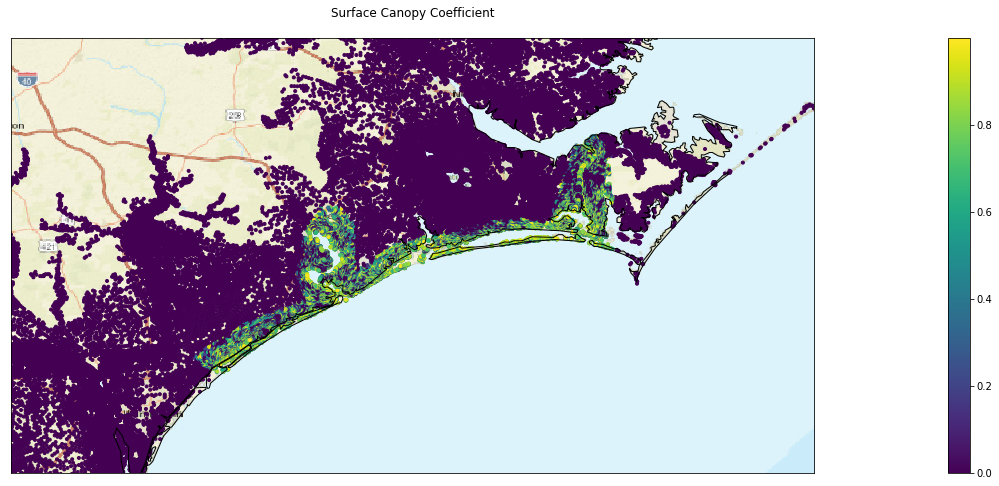

In [10]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['surface_canopy_coefficient']
lat1,lat2 = 34.059, 35.25
lon1,lon2 = -78.25, -76.05
title = 'Surface Canopy Coefficient'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

In [14]:
import xarray as xr
import numpy as np
import pandas as pd
#import holoviews as hv
import geoviews as gv
import geoviews.feature as gf

import cartopy
from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER

from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')

ModuleNotFoundError: No module named 'geoviews'